# HW5 DATASCI W261: Machine Learning at Scale 

* **Name:**  Megan Jasek
* **Email:**  meganjasek@ischool.berkeley.edu
* **Class Name:**  W261-2
* **Week Number:**  5
* **Date:**  6/17/16

## HW 5.0
- What is a data warehouse? What is a Star schema? When is it used?

A data warehouse is a very large repository for data.  It can include many types of data like sales transactions or product inventories.  It can store relational (structured) data but more and more they are used to store unstructured data like tweets or semi-structured data like log files.  A data warehouse creates a base for data analysis activities like business intelligence and data mining.

The Star schema is a type of database schema.  It is made up of one or more fact tables referencing one or more dimension tables.  A fact table holds measurable quantitative information and a dimension table holds descriptive attributes related to the fact data.

??when is star schema used??


## HW 5.1
- In the database world What is 3NF? Does machine learning use data in 3NF? If so why? 
- In what form does ML consume data?
- Why would one use log files that are denormalized?

Relational dbs - allowed for updates to data more easily than flat files

•A staple of business computing from beginning of digital era
•Decomposes fields of data into smaller tables linked by keys
◦This creates the normal forms
•Saves disk space, no need to repeat data
•Easier to make change to one field; temporary lock on table
•Leads to high availability and integrity of data
•Normalization process known as 3NF (third normal form)
•To get full picture, sometimes need to denormalize our data
•Tell me about the big spenders in my customers
•In what form does ML consume data?
Why would one use log files that are denormalized?

## HW 5.2
Using MRJob, implement a hashside join (memory-backed map-side) for left, right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.)

Justify which table you chose as the Left table in this hashside join.

**ANSWER:** There are 2 tables in this problem.  The first one is labeled 'PageID-URL' and it contains Page ID's and the URL's that the id's are associated with.  It contains about 590 records.  The second one is labeled 'PageID-VisitorID' and it contains Page ID's associated with Visitor ID's.  It contains about 130,000 records.  The smaller table (PageID-URL) was chosen to be on the left because when doing the left join there needs to be some way to mark which elements in the PageID-URL are not contained in the PageID-VisitorID table.  Doing this marking will take additional time and space that is proportional to the size of the left table.  In order to minimize time and space, the smaller table was chosen to be on the left.

Please report the number of rows resulting from:

- (1) Left joining Table Left with Table Right
- (2) Right joining Table Left with Table Right
- (3) Inner joining Table Left with Table Right

**ANSWER:**

| Join Type | # of Rows |
| - | - |
| Left | 98,663 |
| Right | 98,654 |
| Inner | 98,654 |  

Since the number of rows for the inner and right joins are the same, this means that there are not any entries in the PageID-VisitorID table that did not have PageID's in the PageID-URL table.

Since the number of rows for the left join is greater than the inner join, this means that there were 9 (98,663 - 98,654) rows in the PageID-URL table that did not have PageID's in the PageID-VisitorID table.

**Algorithm for hashside join** from Data-Intensive Text Processing with MapReduce by Jimmy Lin and Chris Dyer, section 3.5.3, page 67:  
1. Load the smaller dataset into memory in every mapper, populating an associative array to facilitate random access to tuples based on the join key. The mapper initialization API hook (see Section 3.1.1) can be used for this purpose.
2. Mappers are then applied to the other (larger) dataset, and for each input key-value pair, the mapper probes the in-memory dataset to see if there is a tuple with the same join key.
3. If there is, the join is performed.

### HW5.2 (1) Left joining Table Left with Table Right

In [10]:
%%writefile MemJoinLeft.py
from mrjob.job import MRJob
from mrjob.step import MRStep
 
# This class performs left join on the 2 datasets in the input file.
# The left table is Page ID's and URL's.  The right table is Page_ID's and Visitor ID's.
# It will output all rows from the left table, with the matching rows (matching Page ID's)
# in the right table. The output is NULL or blank on the right side when there is no match.
# The output is of the form URL, Page ID, Visitor ID
class MRMemJoinLeft(MRJob):
    # Initialize a dictionary to store the smaller dataset that will be held in memory.
    vroots = {}
    # Initialize a dictionary to keep track of the vroots (page_id's) that did not exist
    # in the right table.
    vroots_not_used = {}
    
    def mapper_memjoin_init(self):
        # Read the data from the filename and store it in the self.vroots dictionary.  This
        # stores the base URL and the vroot labels for each vroot.  For each vroot
        # in the file, store an empty entry for the vroot in the self.vroots_not_used dictionary
        filename = 'anonymous-msweb_converted.data'
        with open(filename, 'r') as f:
            base_url = ""
            for line in f.readlines():
                record = line.strip().split(',')
                if record[0] == 'I':
                    base_url = record[2].strip('"')
                elif record[0] == 'A':
                    page_id = record[1]
                    vroot = record[4].strip('"')
                    self.vroots[page_id] = base_url + vroot
                    self.vroots_not_used[page_id] = ''

    def mapper_memjoin(self, _, line):
        # read the next line from the file and only if it is a visitor record, denoted by
        # 'V', and only if the page_id is in the vroots dictionary, output the URL, Page ID
        # and Visitor ID.  Delete the page_id from the self.vroots_not_used dictionary
        # to indicate that this page_id has been output already.
        record = line.strip().split(',')
        if record[0] == 'V':
            page_id = record[1]
            visitor_id = record[4]
            page_visitor_pair = ('Page ID: %s, Visitor ID: %s' % (page_id, visitor_id))
            if page_id in self.vroots:
                if page_id in self.vroots_not_used:
                    del self.vroots_not_used[page_id]
                yield 'URL: ' + self.vroots[page_id], page_visitor_pair

    def mapper_memjoin_final(self):
        # To complete the left join, for any vroots still left in the self.vroots_not_used
        # dictionary, print them out with a None for the right side.
        for page_id in self.vroots_not_used:
            yield 'URL: ' + self.vroots[page_id], None
    
    # Create the steps for this job.  No reducer is required.
    def steps(self):
        JOBCONF_STEP = {        
            'mapreduce.job.maps': '1'
        }
        return[
            MRStep(jobconf=JOBCONF_STEP,
                   mapper_init=self.mapper_memjoin_init, 
                   mapper=self.mapper_memjoin,
                   mapper_final=self.mapper_memjoin_final)
        ]

if __name__ == '__main__':
    MRMemJoinLeft.run()

Overwriting MemJoinLeft.py


In [12]:
# Test this job with a smaller dataset
#!python MemJoinLeft.py anonymous-msweb_converted_small.data --file=anonymous-msweb_converted_small.data
# Run the job on the full dataset
!python MemJoinLeft.py anonymous-msweb_converted.data --file=anonymous-msweb_converted.data --output-dir=output/leftjoin --no-output
########### HW4.2 OUTPUT:  Number of Rows from Left Join ######
!wc -l output/leftjoin/part-00000

98663 output/leftjoin/part-00000


In [24]:
import MemJoinLeft
reload(MemJoinLeft)

TEST_FILE = False
#mr_job = MemJoinLeft.MRMemJoinLeft(args=['anonymous-msweb_converted_small.data','--file=anonymous-msweb_converted_small.data'])
mr_job = MemJoinLeft.MRMemJoinLeft(args=['anonymous-msweb_converted.data','--file=anonymous-msweb_converted.data'])
with mr_job.make_runner() as runner: 
    runner.run()
    count = 0
    # stream_output: get access of the output 
    for line in runner.stream_output():
        if TEST_FILE:
            key,value =  mr_job.parse_output_line(line)
            if value == None:
                print key
            else:
                print key + ', ' + value
        count = count + 1
print "\n"
print "There are %s records" %count



There are 98663 records


### HW5.2 (2) Right joining Table Left with Table Right

In [14]:
%%writefile MemJoinRight.py
from mrjob.job import MRJob
from mrjob.step import MRStep

# This class performs right join on the 2 datasets in the input file.
# The left table is Page ID's and URL's.  The right table is Page_ID's and Visitor ID's.
# It will output all rows from the right table, with the matching rows (matching Page ID's)
# in the left table. The output is NULL or blank on the left side when there is no match.
# The output is of the form URL, Page ID, Visitor ID
class MRMemJoinRight(MRJob):
    # Create a dictionary to store the smaller dataset that will be held in memory.
    vroots = {}
    
    def mapper_memjoin_init(self):
        # Read the data from the filename and store it in the self.vroots dictionary.  This
        # stores the base URL and the vroot labels for each vroot. 
        filename = 'anonymous-msweb_converted.data'
        with open(filename, 'r') as f:
            base_url = ""
            for line in f.readlines():
                record = line.strip().split(',')
                if record[0] == 'I':
                    base_url = record[2].strip('"')
                elif record[0] == 'A':
                    page_id = record[1]
                    vroot = record[4].strip('"')
                    self.vroots[page_id] = base_url + vroot

    def mapper_memjoin(self, _, line):
        # read the next line from the file examine each line that starts with a 'V'.
        # Yield each of these lines.  If there is no url for one of the lines in the 
        # file, then output it with a url of 'None'.
        record = line.strip().split(',')
        if record[0] == 'V':
            page_id = record[1]
            visitor_id = record[4]
            page_visitor_pair = ('Page ID: %s, Visitor ID: %s' % (page_id, visitor_id))
            url = 'None'
            if page_id in self.vroots:
                url = self.vroots[page_id]
            yield 'URL: ' + url, page_visitor_pair
    
    # Create the steps for this job.  No reducer is required.
    def steps(self):
        return[
            MRStep(mapper_init=self.mapper_memjoin_init, 
                   mapper=self.mapper_memjoin)
        ]

if __name__ == '__main__':
    MRMemJoinRight.run()

Overwriting MemJoinRight.py


In [17]:
# Test this job on a smaller dataset
#!python MemJoinRight.py anonymous-msweb_converted_small.data --file=anonymous-msweb_converted_small.data
# Run this job on the full dataset
!python MemJoinRight.py anonymous-msweb_converted.data --file=anonymous-msweb_converted.data --output-dir=output/rightjoin --no-output
########### HW4.2 OUTPUT:  Number of Rows from Right Join ######
!wc -l output/rightjoin/part-00000
!wc -l output/rightjoin/part-00001
print(49062+49592)

49062 output/rightjoin/part-00000
49592 output/rightjoin/part-00001
98654


In [25]:
import MemJoinRight
reload(MemJoinRight)

TEST_FILE = False
#mr_job = MemJoinRight.MRMemJoinRight(args=['anonymous-msweb_converted_small.data','--file=anonymous-msweb_converted_small.data'])
mr_job = MemJoinRight.MRMemJoinRight(args=['anonymous-msweb_converted.data','--file=anonymous-msweb_converted.data'])
with mr_job.make_runner() as runner: 
    runner.run()
    count = 0
    # stream_output: get access of the output 
    for line in runner.stream_output():
        if TEST_FILE:
            key,value =  mr_job.parse_output_line(line)
            print key + ', ' + value
        count = count + 1
print "\n"
print "There are %s records" %count



There are 98654 records


### HW5.2 (3) Inner joining Table Left with Table Right

In [19]:
%%writefile MemJoinInner.py
from mrjob.job import MRJob
from mrjob.step import MRStep
 
# This class performs an inner join on the 2 datasets in the input file.
# The left table is Page ID's and URL's.  The right table is Page_ID's and Visitor ID's.
# It will only output rows where the Page ID exists in both tables.  The output is 
# of the form URL, Page ID, Visitor ID
class MRMemJoinInner(MRJob):
    # Create a dictionary to store the smaller dataset that will be held in memory.
    vroots = {}
    
    def mapper_memjoin_init(self):
        # Read the data from the filename and store it in the self.vroots dictionary.  This
        # stores the base URL and the vroot labels for each vroot. 
        filename = 'anonymous-msweb_converted.data'
        with open(filename, 'r') as f:
            base_url = ""
            for line in f.readlines():
                record = line.strip().split(',')
                if record[0] == 'I':
                    base_url = record[2].strip('"')
                elif record[0] == 'A':
                    page_id = record[1]
                    vroot = record[4].strip('"')
                    self.vroots[page_id] = base_url + vroot

    def mapper_memjoin(self, _, line):
        # read the next line from the file and only if it is a visitor record, denoted by
        # 'V', and only if the page_id is in the vroots dictionary, output the URL, Page ID
        # and Visitor ID.
        record = line.strip().split(',')
        if record[0] == 'V':
            page_id = record[1]
            visitor_id = record[4]
            page_visitor_pair = ('Page ID: %s, Visitor ID: %s' % (page_id, visitor_id))
            if page_id in self.vroots:
                yield 'URL: ' + self.vroots[page_id], page_visitor_pair
    
    # Create the steps for this job.  No reducer is required.
    def steps(self):
        return[
            MRStep(mapper_init=self.mapper_memjoin_init, 
                   mapper=self.mapper_memjoin)
        ]

if __name__ == '__main__':
    MRMemJoinInner.run()

Overwriting MemJoinInner.py


In [20]:
# Test this job on a smaller dataset
#!python MemJoinInner.py anonymous-msweb_converted_small.data --file=anonymous-msweb_converted_small.data
# Run this job on the full dataset
!python MemJoinInner.py anonymous-msweb_converted.data --file=anonymous-msweb_converted.data --output-dir=output/innerjoin --no-output
########### HW4.2 OUTPUT:  Number of Rows from Inner Join ######
!wc -l output/innerjoin/part-00000
!wc -l output/innerjoin/part-00001
print(49062+49592)

No configs found; falling back on auto-configuration
Running step 1 of 1...
Creating temp directory /tmp/MemJoinInner.hadoop.20160611.051202.927823
Removing temp directory /tmp/MemJoinInner.hadoop.20160611.051202.927823...
49062 output/innerjoin/part-00000
49592 output/innerjoin/part-00001
98654


In [26]:
import MemJoinInner
reload(MemJoinInner)

TEST_FILE = False
#mr_job = MemJoinInner.MRMemJoinInner(args=['anonymous-msweb_converted_small.data','--file=anonymous-msweb_converted_small.data'])
mr_job = MemJoinInner.MRMemJoinInner(args=['anonymous-msweb_converted.data','--file=anonymous-msweb_converted.data'])
with mr_job.make_runner() as runner: 
    runner.run()
    count = 0
    # stream_output: get access of the output 
    for line in runner.stream_output():
        if TEST_FILE:
            key,value =  mr_job.parse_output_line(line)
            print key + ', ' + value
        count = count + 1
print "\n"
print "There are %s records" %count



There are 98654 records


## HW 5.3  EDA of Google n-grams dataset
A large subset of the Google n-grams dataset

https://aws.amazon.com/datasets/google-books-ngrams/

which we have placed in a bucket/folder on Dropbox on s3:

https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=0 

s3://filtered-5grams/

In particular, this bucket contains (~200) files (10Meg each) in the format:

	(ngram) \t (count) \t (pages_count) \t (books_count)

For HW 5.3-5.5, for the Google n-grams dataset unit test and regression test your code using the 
first 10 lines of the following file:

googlebooks-eng-all-5gram-20090715-0-filtered.txt

Once you are happy with your test results proceed to generating  your results on the Google n-grams dataset. 

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)  
**ANSWER:**  There were two 5-grams with the longest length of 155 characters.  Spaces and apostrophes were not counted.
"AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR"	155
"ROPLEZIMPREDASTRODONBRASLPKLSON YHROACLMPARCHEYXMMIOUDAVESAURUS PIOFPILOCOWERSURUASOGETSESNEGCP TYRAVOPSIFENGOQUAPIALLOBOSKENUO OWINFUYAIOKENECKSASXHYILPOYNUAT"	155

- Top 10 most frequent words (please use the count information), i.e., unigrams  
**ANSWER:**  
"the"	5,490,815,394  
"of"	3,698,583,299  
"to"	2,227,866,570  
"in"	1,421,312,776  
"a"	1,361,123,022  
"and"	1,149,577,477  
"that"	802,921,147  
"is"	758,328,796  
"be"	688,707,130  
"as"	492,170,314  

- 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency  
**ANSWER:**  
**20 MOST DENSE WORDS**  
"xxxx"	11.557291666666666  
"blah"	8.074159907300116  
"nnn"	7.533333333333333  
"na"	6.201749131424464  
"oooooooooooooooo"	4.921875  
"nd"	4.85430572723527  
"llll"	4.511627906976744  
"oooooo"	4.169650013358269  
"ooooo"	3.858637193467213  
"lillelu"	3.7624521072796937  
"madarassy"	3.576923076923077  
"pfeffermann"	3.576923076923077  
"meteoritical"	3.56  
"xxxxxxxx"	3.5  
"beep"	3.229038854805726  
"latha"	3.188679245283019  
"iyengar"	2.9191176470588234  
"counterfeiteth"	2.825  
"nonmorular"	2.81981981981982  
"nonsquamous"	2.81981981981982  
**20 LEAST DENSE WORDS**  
"zwingst"	1.0  
"zwirnen"	1.0  
"zwischenstaatlicher"	1.0  
"zwitterionic"	1.0  
"zwt"	1.0  
"zwyn"	1.0  
"zx"	1.0  
"zxcvframeqasfuc"	1.0  
"zydeco"	1.0  
"zydom"	1.0  
"zygmunt"	1.0  
"zygomaticofacial"	1.0  
"zygomaticotemporal"	1.0  
"zygosity"	1.0  
"zylindrischen"	1.0  
"zymelman"	1.0  
"zymogens"	1.0  
"zymophore"	1.0  
"zymosan"	1.0  
"zymosis"	1.0  

- Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.  
**ANSWER:**  See histogram plotted below in section labeled: 'OUTPUT FOR:  Distribution of 5-gram sizes (character length)'

### HW5.3 EDA:  Longest 5-gram

In [6]:
%%writefile EDALongest5gram.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re
    
# This class outputs the 5-grams from the input file in descending order based
# on the number of characters in the 5-gram.
class MREDALongest5gram(MRJob):
    def mapper_count_chars(self, _, line):
        # read the next line from the file and output the first record (the 5-gram) with the count
        # of its characters.
        record = line.strip().split('\t')
        # Remove spaces and apostrophes
        ngram = re.sub("[' ]", '', record[0])
        yield record[0], len(ngram)
    
    def reducer_sum_chars(self, ngram, counts):
        # output each ngram (key) that is input to the reducer plus the sum of the counts.
        yield ngram, sum(counts)
    
    def reducer_sort_chars(self, ngram, counts):
        # output each ngram (key) that is input to the reducer plus the sum of the counts
        # for that page.  (NOTE:  There should only be one count value for each ngram.)
        yield ngram, sum(counts)
        
    def steps(self):
        # define the steps this MR job.  The JOBCONF_STEP2 tells Hadoop how to handle the data during
        # the Hadoop shuffle for the 2nd job.  In this case the data should be sorted in reverse order
        # by the 2nd output (in this case the values or counts of the characters) and then if there are ties,
        # the data should be sorted by first output or the key.
        JOBCONF_STEP2 = {        
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 2,
            'stream.map.output.field.separator':',',
            'mapreduce.partition.keycomparator.options': '-k2,2nr -k1,1',
            'mapreduce.job.reduces': '1'
        }
        return [
            MRStep(mapper=self.mapper_count_chars,   # STEP 1:  count the characters
                   reducer=self.reducer_sum_chars),
            MRStep(jobconf=JOBCONF_STEP2,
                    reducer=self.reducer_sort_chars)  # STEP 2:  sort the characters
        ]

if __name__ == '__main__':
    MREDALongest5gram.run()

Overwriting EDALongest5gram.py


In [1]:
# Test the program on the small dataset
!python EDALongest5gram.py 5gram_small.txt 

No configs found; falling back on auto-configuration
Creating temp directory /tmp/EDALongest5gram.hadoop.20160612.002359.463775
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/EDALongest5gram.hadoop.20160612.002359.463775/output...
"A BILL FOR ESTABLISHING RELIGIOUS"	29
"A Biography of General George"	25
"A Case Study in Government"	22
"A Case Study of Female"	18
"A Case Study of Limited"	19
"A Child's Christmas in Wales"	23
"A Circumstantial Narrative of the"	29
"A City by the Sea"	13
"A Collection of Fairy Tales"	23
"A Collection of Forms of"	20
Removing temp directory /tmp/EDALongest5gram.hadoop.20160612.002359.463775...


In [3]:
### Upload test files to HDFS for testing
#!hdfs dfs -copyFromLocal '5gram_small.txt' /user/hadoop
#!hdfs dfs -copyFromLocal 'data-test/googlebooks-eng-all-5gram-20090715-0-filtered_half.txt' /user/hadoop
#!hdfs dfs -mkdir /user/hadoop/HW5data-test
#!hdfs dfs -rm /user/hadoop/HW5data-test/googlebooks-eng-all-5gram-20090715-0-filtered_head.txt
#!hdfs dfs -copyFromLocal 'data-test/googlebooks-eng-all-5gram-20090715-0-filtered_head.txt' /user/hadoop/HW5data-test
#!hdfs dfs -copyFromLocal 'data-test/googlebooks-eng-all-5gram-20090715-0-filtered_tail.txt' /user/hadoop/HW5data-test

16/06/11 12:57:11 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/11 12:57:13 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
## HDFS file locations
ifile = 'hdfs:///user/hadoop/HW5data/'
## Local file locations
#ifile = '5gram_small.txt'
ofile = 'outputHW5/EDALongest5gram'
!hdfs dfs -rm -r /user/hadoop/$ofile
!nohup python EDALongest5gram.py -r hadoop $ifile --output-dir=$ofile --no-output

16/06/11 17:40:13 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `/user/hadoop/outputHW5/EDALongest5gram': No such file or directory
nohup: ignoring input and appending output to ‘nohup.out’


In [6]:
##### OUTPUT FOR HW5.3 LONGEST 5-GRAM #####
!hdfs dfs -cat outputHW5/EDALongest5gram/part-00000 | head -5

16/06/11 19:06:05 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR"	155
"ROPLEZIMPREDASTRODONBRASLPKLSON YHROACLMPARCHEYXMMIOUDAVESAURUS PIOFPILOCOWERSURUASOGETSESNEGCP TYRAVOPSIFENGOQUAPIALLOBOSKENUO OWINFUYAIOKENECKSASXHYILPOYNUAT"	155
"RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR JDDUMHUYPARICOLEVTYPS ILONBUNURT"	124
"RTYEARTHQUAKECVBNMKDSAW VBNEVWVOLCANICERUPTIONS FLOODSCVBEAVALANCHESUYT VBNHURRICANESTORNADOESX TIDALWAVECVBNCYCLONECVE"	115
"SHIPWRECKIERTGBVCXWQXCE CCCVBNWSESWDFGFIRESNPLM WQRAILROADWRECKSUTRFHJK EXPLOSIONSTRPIQURECEDFG RTYEARTHQUAKECVBNMKDSAW"	115
cat: Unable to write to output stream.


In [13]:
import EDALongest5gram
reload(EDALongest5gram)

mr_job = EDALongest5gram.MREDALongest5gram(args=['5gram_small.txt', '-r', 'hadoop'])
with mr_job.make_runner() as runner: 
    runner.run()
    count = 0
    cur_value = ""
    # stream_output: get access of the output 
    # Only output the longest ngram.  If there are multiple ngrams with the longest 
    # number of characters, then output all of them, sorted alphabetically
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        if count == 0 or value == cur_value:
            print key, value
            cur_value = value
        else:
            break
        count += 1


ERROR:mrjob.fs.hadoop:STDERR: 16/06/10 16:38:11 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



A BILL FOR ESTABLISHING RELIGIOUS 29
A Circumstantial Narrative of the 29


### HW5.3 EDA:  Top 10 most frequent words (please use the count information), i.e., unigrams

In [3]:
%%writefile EDAMostFrequentWords.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re
    
# This class outputs the 5-grams from the input file in descending order based
# on the number of characters in the 5-gram.
class MREDAMostFrequentWords(MRJob):
    def mapper_count_chars(self, _, line):
        # read the next line from the file and output the first record (the 5-gram) with the count
        # of its characters.
        record = line.strip().split('\t')
        words = record[0].lower().split()
        for word in words:
            yield word, int(record[1])
    
    def reducer_sum_chars(self, word, counts):
        # output each word (key) that is input to the reducer plus the sum of the counts.
        yield word, sum(counts)
    
    def reducer_sort_chars(self, word, counts):
        # output each ngram (key) that is input to the reducer plus the sum of the counts
        # for that page.  (NOTE:  There should only be one count value for each ngram.)
        yield word, sum(counts)
        
    def steps(self):
        # define the steps this MR job.  The JOBCONF_STEP2 tells Hadoop how to handle the data during
        # the Hadoop shuffle for the 2nd job.  In this case the data should be sorted in reverse order
        # by the 2nd output (in this case the values or counts of the words) and then if there are ties,
        # the data should be sorted by first output or the key.
        JOBCONF_STEP2 = {        
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 2,
            'stream.map.output.field.separator':',',
            'mapreduce.partition.keycomparator.options': '-k2,2nr -k1,1',
            'mapreduce.job.reduces': '1'
        }
        return [
            MRStep(mapper=self.mapper_count_chars,   # STEP 1:  count the characters
                   combiner=self.reducer_sum_chars,
                   reducer=self.reducer_sum_chars),
            MRStep(jobconf=JOBCONF_STEP2,
                    reducer=self.reducer_sort_chars)  # STEP 2:  sort the characters
        ]

if __name__ == '__main__':
    MREDAMostFrequentWords.run()

Overwriting EDAMostFrequentWords.py


In [40]:
import EDAMostFrequentWords
reload(EDAMostFrequentWords)

mr_job = EDAMostFrequentWords.MREDAMostFrequentWords(args=['5gram_small.txt', '-r', 'hadoop'])
with mr_job.make_runner() as runner: 
    runner.run()
    count = 0
    # stream_output: get access of the output 
    # Only output the longest ngram.  If there are multiple ngrams with the longest 
    # number of characters, then output all of them, sorted alphabetically
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        if count < 10:
            print key, value
        else:
            break
        count += 1


ERROR:mrjob.fs.hadoop:STDERR: 16/06/10 18:42:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



a 2217
in 1201
child's 1099
christmas 1099
wales 1099
of 1011
case 604
study 604
female 447
collection 239


In [4]:
## HDFS file locations
ifile = 'hdfs:///user/hadoop/HW5data/'
## Local file locations
#ifile = '5gram_small.txt'
ofile = 'outputHW5/EDAMostFrequent'
!hdfs dfs -rm -r /user/hadoop/$ofile
!nohup python EDAMostFrequentWords.py -r hadoop $ifile --output-dir=$ofile --no-output

In [5]:
##### OUTPUT FOR HW5.3 MOST FREQUENT WORD #####
!hdfs dfs -cat outputHW5/EDAMostFrequent/part-00000 | head -10

16/06/11 20:11:31 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"the"	5490815394
"of"	3698583299
"to"	2227866570
"in"	1421312776
"a"	1361123022
"and"	1149577477
"that"	802921147
"is"	758328796
"be"	688707130
"as"	492170314
cat: Unable to write to output stream.


### HW5.3 EDA:  20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency

In [1]:
%%writefile EDAWordDensity.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re
    
# This class outputs the words in decreasing order of density (count/pages_count)
class MREDAWordDensity(MRJob):
    def mapper_count(self, _, line):
        # read the next line from the file and output each word of the 5-gram and
        # its count and page_count
        record = line.strip().split('\t')
        words = record[0].lower().split()
        for word in words:
            yield word, (int(record[1]), int(record[2]))
    
    def reducer_sum(self, word, counts):
        # output each word (key) that is input to the reducer plus the sum of the 
        # word_counts and page_counts
        word_total = 0
        page_total = 0
        for word_count, pages_count in counts:
            word_total += word_count
            page_total += pages_count
        yield word, (word_total, page_total)
    
    def mapper_density(self, word, counts):
        # output the word plus the word density (word_total / page_total)
        word_total = float(counts[0])
        page_total = float(counts[1])
        yield word, word_total / page_total

    def reducer_sort(self, word, counts):
        # output each word (key) that is input to the reducer plus the sum of the counts
        # for that page.  (NOTE:  There should only be one count value for each ngram.)
        yield word, sum(counts)
        
    def steps(self):
        # define the steps this MR job.  The JOBCONF_STEP2 tells Hadoop how to handle the data during
        # the Hadoop shuffle for the 2nd job.  In this case the data should be sorted in reverse order
        # by the 2nd output (in this case the values or counts of the words) and then if there are ties,
        # the data should be sorted by first output or the key.
        JOBCONF_STEP2 = {        
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 2,
            'stream.map.output.field.separator':',',
            'mapreduce.partition.keycomparator.options': '-k2,2nr -k1,1',
            'mapreduce.job.reduces': '1'
        }
        return [
            MRStep(mapper=self.mapper_count,   # STEP 1:  count the words and pages
                   combiner=self.reducer_sum,
                   reducer=self.reducer_sum),
            MRStep(jobconf=JOBCONF_STEP2,      # STEP 2:  compute and sort the densities
                   mapper=self.mapper_density,
                   reducer=self.reducer_sort)  
        ]

if __name__ == '__main__':
    MREDAWordDensity.run()

Overwriting EDAWordDensity.py


In [1]:
!python EDAWordDensity.py 5gram_small.txt | head -10

No configs found; falling back on auto-configuration
Creating temp directory /tmp/EDAWordDensity.hadoop.20160612.012009.966284
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/EDAWordDensity.hadoop.20160612.012009.966284/output...
"a"	1.0282931354359925
"bill"	1.0
"biography"	1.0222222222222221
"by"	1.0333333333333334
"case"	1.0
"child's"	1.0358152686145146
"christmas"	1.0358152686145146
"circumstantial"	1.0
"city"	1.0333333333333334
"collection"	1.0863636363636364
Removing temp directory /tmp/EDAWordDensity.hadoop.20160612.012009.966284...


In [2]:
import EDAWordDensity
reload(EDAWordDensity)

#mr_job = EDAWordDensity.MREDAWordDensity(args=['5gram_small.txt'])
mr_job = EDAWordDensity.MREDAWordDensity(args=['5gram_small.txt', '-r', 'hadoop'])
with mr_job.make_runner() as runner: 
    runner.run()
    count = 0
    # stream_output: get access of the output 
    # Output the words and their densities in descending order by density
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        #print key, value
        count += 1


ERROR:mrjob.fs.hadoop:STDERR: 16/06/11 20:21:43 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



In [4]:
## HDFS file locations
ifile = 'hdfs:///user/hadoop/HW5data/'
## Local file locations
#ifile = '5gram_small.txt'
ofile = 'outputHW5/EDAWordDensity'
!hdfs dfs -rm -r /user/hadoop/$ofile
!nohup python EDAWordDensity.py -r hadoop $ifile --output-dir=$ofile --no-output

In [3]:
##### OUTPUT FOR HW5.3 MOST/LEAST WORD DENSITY #####
#!hdfs dfs -cat outputHW5/EDAWordDensity/part-00000 | head -20
#!hdfs dfs -cat outputHW5/EDAWordDensity/part-00000 | tail -20

### HW5.3 EDA:  Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

In [12]:
%%writefile EDALengthCount.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re
    
# This class outputs the unique lengths of the 5-grams and the frequency of those lengths
class MREDALengthCount(MRJob):
    def mapper_count_lengths(self, _, line):
        # read the next line from the file and output the length of the 5-gram and the count
        record = line.strip().split('\t')
        # Remove spaces and apostrophes
        ngram = re.sub("[' ]", '', record[0])
        yield len(ngram), int(record[1])
    
    def reducer_sum_lengths(self, length, counts):
        # output each length (key) that is input to the reducer plus the sum of the counts.
        yield length, sum(counts)
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper_count_lengths,   # STEP 1:  count the lengths
                   combiner=self.reducer_sum_lengths,
                   reducer=self.reducer_sum_lengths)
        ]

if __name__ == '__main__':
    MREDALengthCount.run()

Overwriting EDALengthCount.py


In [4]:
import EDALengthCount
reload(EDALengthCount)

mr_job = EDALengthCount.MREDALengthCount(args=['5gram_small.txt'])
#mr_job = EDALengthCount.MREDALengthCount(args=['5gram_small.txt', '-r', 'hadoop'])
with mr_job.make_runner() as runner: 
    runner.run()
    # Initialize a dictionary to store the lengths and frequencies
    len_freq = {}
    # stream_output: get access of the output 
    # the key is the length of a 5-gram and the value is number of times that
    # length occurs.
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        #print key, value
        len_freq[int(key)] = int(value)

In [4]:
%matplotlib inline
import pandas

# Plot a histogram of the lengths and their frequencies
#df = pandas.DataFrame.from_dict(len_freq, orient='index')
#df = df.sort_index()
#df.plot(kind='bar', figsize=(5,5), legend=False, title='Distribution of 5-gram sizes (character length)')

In [4]:
## HDFS file locations
ifile = 'hdfs:///user/hadoop/HW5data/'
## Local file locations
#ifile = '5gram_small.txt'
ofile = 'outputHW5/EDALengthCount'
!hdfs dfs -rm -r /user/hadoop/$ofile
!nohup python EDALengthCount.py -r hadoop $ifile --output-dir=$ofile --no-output

In [21]:
##### OUTPUT FOR HW5.3 5-GRAM LENGTH DISTRIBUTIONS #####
#!hdfs dfs -cat outputHW5/EDALengthCount/part-00000 | wc -l
#!hdfs dfs -cat outputHW5/EDALengthCount/part-00000 | sort -k2nr | head -10
#!hdfs dfs -cat outputHW5/EDALengthCount/part-00000 | sort -k2nr | tail -10
#!hdfs dfs -copyToLocal outputHW5/EDALengthCount/part-00000 EDALengthCount_results.text

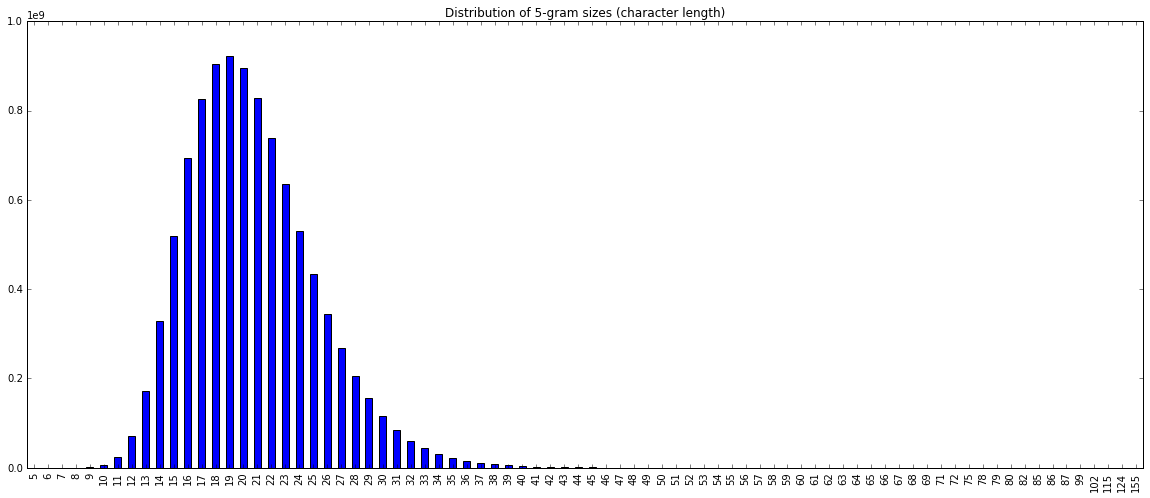

In [1]:
##### OUTPUT FOR HW5.3 5-GRAM LENGTH DISTRIBUTIONS #####
%matplotlib inline
import pandas

# Initialize a dictionary to store the lengths and frequencies
len_freq = {}
filename = 'EDALengthCount_results.text'
with open(filename, 'r') as f:
    for line in f.readlines():
        key,value =  line.strip().split('\t',2)
        len_freq[int(key)] = int(value)

#http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

# Plot a histogram of the lengths and their frequencies
df = pandas.DataFrame.from_dict(len_freq, orient='index')
df = df.sort_index()
df.plot(kind='bar', figsize=(20,8), legend=False,
        title='Distribution of 5-gram sizes (character length)')

## HW 5.4  Synonym detection over 2Gig of Data

For the remainder of this assignment you will work with two datasets:

### 1: unit/systems test data set: SYSTEMS TEST DATASET
Three terms, A,B,C and their corresponding strip-docs of co-occurring terms

- DocA {X:20, Y:30, Z:5}
- DocB {X:100, Y:20}
- DocC {M:5, N:20, Z:5}

### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with you system.

In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset. To accomplish
this you must script two main tasks using MRJob:

(1) Build stripes for the most frequent 10,000 words using cooccurence informationa based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


(2) Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

==Design notes for (1)==
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for (2).

==Design notes for (2)==
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

70,050,680 / 2 = 35,025,340 pairs

#### Create Extended Systems Test Data and Load it in to HDFS

In [3]:
%%writefile ext_systems_test_Stripes.txt
"also.3"	{"expected": 20, "years": 30, "size": 5}
"back.2"	{"expected": 100, "years": 20}
"case.4"	{"may": 5, "new": 20, "size": 5, "years": 1}

Overwriting ext_systems_test_Stripes.txt


In [7]:
#!cat ext_systems_test_Stripes.txt
#!hdfs dfs -copyFromLocal ext_systems_test_Stripes.txt /user/hadoop
#!hdfs dfs -ls /user/hadoop

In [1]:
%%writefile Stripes5Gram.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re
from collections import Counter
    
# This class outputs stripes for the top 10,000 most frequent words.  In each of the stripes
# are the counts of how many times each feature (the 9,001 to 10,000 most frequent words occur)
# occur.  Symmetry is preserved.
class MRStripes5Gram(MRJob):
    freq_words = set()
    features = set()
    
    # Create sets for storing the frequent words and the features
    def mapper_stripes_init(self):
        self.word_stripe_counts = {}
        with open('5-4words.txt', 'r') as f:
            count = 0
            for line in f.readlines():
                if count < 10000:
                    self.freq_words.add(line.strip())
                else:
                    self.features.add(line.strip())
                count += 1
    
    def mapper_stripes(self, _, line):
        record = line.strip().split('\t')
        words = record[0].lower().split()
        count = int(record[1])
        # loop through all of the words from the line and create
        # a stripe that contains all of the co-occuring words (except itself)
        # and their counts.
        for w1 in words:
            if w1 in self.freq_words:
                H = {}
                for w2 in words:
                    if (w1 != w2) and (w2 in self.features):
                        if w2 in H:
                            H[w2] += count
                        else:
                            H[w2] = count
                if H != {}:
                    yield w1, H

    # sum the values in the stripes for common words
    def combiner_stripes(self, word, counts):
        sum_H = Counter()
        for H in counts:
            sum_H += Counter(H)
        yield word, sum_H

    # sum the values in the stripes for common words
    # also attach the length of the stripe to the key with a period
    # this is the cardinality of that word to be used for 
    # jaccard similarity later.
    def reducer_stripes(self, word, counts):
        sum_H = Counter()
        for H in counts:
            sum_H += Counter(H)
        yield word+'.'+str(len(sum_H)), sum_H
    
    def steps(self):
        JOBCONF_STEP = {        
            'mapreduce.job.reduces': '2'             # Specify 2 reducers
        }
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper_init=self.mapper_stripes_init, mapper=self.mapper_stripes, 
                   combiner=self.combiner_stripes,
                   reducer=self.reducer_stripes)
        ]

if __name__ == '__main__':
    MRStripes5Gram.run()

Overwriting Stripes5Gram.py


In [15]:
# Add required files to HDFS
#!hdfs dfs -rm /user/hadoop/megan_test.txt
#!hdfs dfs -copyFromLocal 'megan_test.txt' /user/hadoop
#!hdfs dfs -rm '5-4words.txt' /user/hadoop
#!hdfs dfs -copyFromLocal '5-4words.txt' /user/hadoop
#!hdfs dfs -mkdir /user/hadoop/HW5Results
#!hdfs dfs -ls

In [17]:
## Local TESTS
#ifile = 'megan_test.txt'
## HDFS TESTS
#ifile = 'hdfs:///user/hadoop/HW5data/'
#ifile = 'hdfs:///user/hadoop/HW5data-test/'
ifile = 'hdfs:///user/hadoop/HW5data-test/googlebooks-eng-all-5gram-20090715-0-filtered_head.txt'
#ifile = 'hdfs:///user/hadoop/megan_test.txt'
ofile = 'outputHW5/Stripes5Gram'
!hdfs dfs -rm -r /user/hadoop/$ofile
#!nohup python Stripes5Gram.py -r hadoop $ifile --output-dir=$ofile --no-output
!python Stripes5Gram.py -r hadoop $ifile --output-dir=$ofile --file='5-4words.txt'

16/06/15 23:34:21 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/15 23:34:22 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW5/Stripes5Gram
No configs found; falling back on auto-configuration
Looking for hadoop binary in /usr/local/hadoop/bin...
Found hadoop binary: /usr/local/hadoop/bin/hadoop
Creating temp directory /tmp/Stripes5Gram.hadoop.20160616.043422.582477
Using Hadoop version 2.7.1
Copying local files to hdfs:///user/hadoop/tmp/mrjob/Stripes5Gram.hadoop.20160616.043422.582477/files/...
Looking for Hadoop streaming jar in /usr/local/hadoop...
Found Hadoop streaming jar: /usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar
Running step 1 of 1...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop

In [2]:
##### OUTPUT FOR HW5.4 STRIPES #####
#!hdfs dfs -cat outputHW5/Stripes5Gram/part-00000 | head -1
#!hdfs dfs -cat outputHW5/Stripes5Gram/part-00001 | head
#!hdfs dfs -cat outputHW5/Stripes5Gram/part-00000 > stripes_2.txt
#!hdfs dfs -cat outputHW5/Stripes5Gram/part-00001 >> stripes_2.txt
#!hdfs dfs -copyFromLocal stripes_2.txt HW5Results
#!hdfs dfs -rm megan_test_Stripes.txt
#!hdfs dfs -cp outputHW5/Stripes5Gram/part-00000 megan_test_Stripes.txt
#!hdfs dfs -cat megan_test_Stripes.txt
#!hdfs dfs -copyToLocal outputHW5/Stripes5Gram/part-00000 megan_test_Stripes.txt

In [3]:
%%writefile InvIndex5Gram.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
from collections import Counter
    
# This class takes stripes as inputs, binarizes them (sets all of the counts of the words
# in the stripe to 1), normalizes them (divides them by the square root of their length)
# and inverts the stripe matrix.
class MRInvIndex5Gram(MRJob):
    word_stripe_counts = {}

    # set all word counts to 1
    def binarize_stripe(self, stripe):
        for w in stripe:
            stripe[w] = 1
        return stripe
    
    # divide all word counts by the square root of their length
    def normalize_stripe(self, stripe):
        length = float(len(stripe))
        for w in stripe:
            stripe[w] /= pow(length, 0.5)
        return stripe
    
    # invert the stripes matrix.
    def mapper_inv_index(self, _, data):
        word, stripe = data.split('\t')
        word = word.strip('"')
        stripe = ast.literal_eval(stripe)
        bin_stripe = self.binarize_stripe(stripe)
        norm_stripe = self.normalize_stripe(bin_stripe)
        for w, value in norm_stripe.iteritems():
            H = {}
            H[word] = value
            yield w, H

    # sum the values in the stripes for common words
    def reducer_inv_index(self, word, counts):
        sum_H = Counter()
        for H in counts:
            sum_H += Counter(H)
        yield word, sum_H
    
    def steps(self):
        JOBCONF_STEP = {        
            'mapreduce.job.reduces': '2'                   # Set number of reducers to 2
        }
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper_inv_index,
                   combiner=self.reducer_inv_index,
                   reducer=self.reducer_inv_index)
        ]

if __name__ == '__main__':
    MRInvIndex5Gram.run()

Overwriting InvIndex5Gram.py


In [8]:
## Local file locations
#ifile = 'systems_test_Stripes.txt'
#ifile = 'megan_test_Stripes.txt'
ifile = 'ext_systems_test_Stripes.txt'
## HDFS file locations
#ifile = 'hdfs:///user/hadoop/systems_test_Stripes.txt'
#ifile = 'hdfs:///user/hadoop/megan_test_Stripes.txt'
#ifile = 'hdfs:///user/hadoop/outputHW5/Stripes5Gram'
ofile = 'outputHW5/InvIndex5Gram'
#!hdfs dfs -rm /user/hadoop/outputHW5/Stripes5Gram/_SUCCESS
#!hdfs dfs -rm -r /user/hadoop/$ofile
#!nohup python InvIndex5Gram.py -r hadoop $ifile --output-dir=$ofile --no-output
!python InvIndex5Gram.py $ifile --output-dir=$ofile

No configs found; falling back on auto-configuration
Running step 1 of 1...
Creating temp directory /tmp/InvIndex5Gram.hadoop.20160617.135658.524173
Streaming final output from outputHW5/InvIndex5Gram...
"years"	{"back.2": 0.7071067811865475, "case.4": 0.5, "also.3": 0.5773502691896258}
"expected"	{"back.2": 0.7071067811865475, "also.3": 0.5773502691896258}
"may"	{"case.4": 0.5}
"new"	{"case.4": 0.5}
"size"	{"case.4": 0.5, "also.3": 0.5773502691896258}
Removing temp directory /tmp/InvIndex5Gram.hadoop.20160617.135658.524173...


In [9]:
%%writefile ext_systems_test_InvIndex.txt
"years"	{"back.2": 0.7071067811865475, "case.4": 0.5, "also.3": 0.5773502691896258}
"expected"	{"back.2": 0.7071067811865475, "also.3": 0.5773502691896258}
"may"	{"case.4": 0.5}
"new"	{"case.4": 0.5}
"size"	{"case.4": 0.5, "also.3": 0.5773502691896258}

Writing ext_systems_test_InvIndex.txt


In [12]:
## Load the test case in to HDFS
#!cat ext_systems_test_InvIndex.txt
#!hdfs dfs -copyFromLocal ext_systems_test_InvIndex.txt /user/hadoop
#!hdfs dfs -ls /user/hadoop

In [4]:
##### OUTPUT FOR HW5.4 INVERTED INDEX #####
#!hdfs dfs -rm 'systems_test_Stripes.txt'
#!hdfs dfs -rm 'megan_test_Stripes.txt'
#!hdfs dfs -copyFromLocal 'systems_test_Stripes.txt' /user/hadoop
#!hdfs dfs -copyFromLocal 'megan_test_Stripes.txt' /user/hadoop
#!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00000 | tail -1
#!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00001 | tail -1
!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00000 > inverted_index_2.txt
!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00001 >> inverted_index_2.txt
!hdfs dfs -copyFromLocal inverted_index_2.txt HW5Results
#!hdfs dfs -rm outputHW5/InvIndex5Gram/_SUCCESS
#!hdfs dfs -ls outputHW5/InvIndex5Gram
#!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00000 | head -20
#!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00000 | wc -l
#!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00000 | tail -20
#!hdfs dfs -cp outputHW5/InvIndex5Gram/part-00000 HW5Results/inverted_index_full.txt
#!hdfs dfs -cp outputHW5/InvIndex5Gram/part-00000 megan_test_InvIndex.txt
#!hdfs dfs -rm megan_test_InvIndex.txt
#!hdfs dfs -cp outputHW5/InvIndex5Gram/part-00000 megan_test_InvIndex.txt
#!hdfs dfs -cp megan_test_InvIndex.txt HW5Results/megan_test_InvIndex.txt
#!hdfs dfs -copyToLocal systems_test_InvIndex.txt
#!hdfs dfs -copyToLocal megan_test_InvIndex.txt
#!hdfs dfs -cat systems_test_InvIndex.txt

16/06/16 00:22:57 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/16 00:22:59 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/16 00:23:02 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [11]:
%%writefile Similarity5Gram.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import Counter
import ast
    
# This class calculates the cosine similarity and the jaccard similarity from
# an inverted index
class MRSimilarity5Gram(MRJob):
    def mapper_similarity(self, _, data):
        word, stripe = data.split('\t')
        word = word.strip('"')
        stripe = ast.literal_eval(stripe)
        # If there is only 1 word in the stripe, this will be []
        keys1 = stripe.keys()[:-1]
        # Loop through all of the keys except the last one
        for i, w1 in enumerate(keys1):
            # Loop through all of the keys following w1 in the stripe
            keys2 = stripe.keys()[i+1:]
            for w2 in keys2:
                # Calculate the dot product for cosine similarity
                cosine = stripe[w1]*stripe[w2]
                # Yield the dot product and a count of 1 for jaccard similarity
                yield (w1,w2), (cosine,1)

    # Sum the values for cosine and jaccard similarities for each key
    def combiner_similarity(self, word, data):
        cosine = 0
        jaccard = 0
        for d in data:
            cosine += d[0]
            jaccard += d[1]
        yield word, (cosine,jaccard)
    
    # Sum the values for cosine and jaccard similarities for each key
    # Calculate the jaccard similarity using the formula |w1 and w2| / |w1| + |w2| - |w1 and w2|
    def reducer_similarity(self, word, data):
        w1, c1 = word[0].split('.')
        w2, c2 = word[1].split('.')
        cosine = 0
        jac_and = 0
        for d in data:
            cosine += d[0]
            jac_and += d[1]
        jaccard = jac_and / float(int(c1) + int(c2) - jac_and)
        yield ('%s.%s.%s' % (w1,w2,'C')), cosine
        yield ('%s.%s.%s' % (w1,w2,'J')), jaccard
    
    def steps(self):
        JOBCONF_STEP1 = {        
            'mapreduce.job.maps': '20',
            'mapreduce.job.reduces': '10'
        }
        return [
            MRStep(jobconf=JOBCONF_STEP1,             # STEP 1:  calculate the similarity
                   mapper=self.mapper_similarity,  
                   combiner=self.combiner_similarity,
                   reducer=self.reducer_similarity)
        ]

if __name__ == '__main__':
    MRSimilarity5Gram.run()

Overwriting Similarity5Gram.py


In [12]:
## Local file locations
#ifile = 'megan_test_InvIndex.txt'
#ifile = 'systems_test_InvIndex.txt'
#ifile = 'ext_systems_test_InvIndex.txt'
## HDFS file locations
#ifile = 'hdfs:///user/hadoop/HW5data/'
#ifile = 'hdfs:///user/hadoop/megan_test_InvIndex.txt'
#ifile = 'hdfs:///user/hadoop/systems_test_InvIndex.txt'
ifile = 'hdfs:///user/hadoop/ext_systems_test_InvIndex.txt'
#ifile = 'hdfs:///user/hadoop/outputHW5/InvIndex5Gram'
ofile = 'outputHW5/Similarity5Gram'
#!hdfs dfs -rm /user/hadoop/outputHW5/InvIndex5Gram/_SUCCESS
!hdfs dfs -rm -r /user/hadoop/$ofile
#!nohup python Similarity5Gram.py -r hadoop $ifile --output-dir=$ofile --no-output
!python Similarity5Gram.py -r hadoop $ifile --output-dir=$ofile

16/06/17 15:03:50 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `/user/hadoop/outputHW5/Similarity5Gram': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /usr/local/hadoop/bin...
Found hadoop binary: /usr/local/hadoop/bin/hadoop
Creating temp directory /tmp/Similarity5Gram.hadoop.20160617.200351.745415
Using Hadoop version 2.7.1
Copying local files to hdfs:///user/hadoop/tmp/mrjob/Similarity5Gram.hadoop.20160617.200351.745415/files/...
Looking for Hadoop streaming jar in /usr/local/hadoop...
Found Hadoop streaming jar: /usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar
Running step 1 of 1...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar6717802256650680558/] [] /tmp/streamjob7592715341755700822.jar tmpDir=null
  Connecting to Resour

In [18]:
##### OUTPUT FOR HW5.4 SIMILARITY CALCULATION #####
#!hdfs dfs -ls outputHW5/Similarity5Gram
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00000
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00001
!hdfs dfs -cat outputHW5/Similarity5Gram/part-00000 > ext_systems_test_Similarity.txt
!hdfs dfs -cat outputHW5/Similarity5Gram/part-00001 >> ext_systems_test_Similarity.txt
!hdfs dfs -copyFromLocal ext_systems_test_Similarity.txt HW5Results
!hdfs dfs -copyFromLocal ext_systems_test_Similarity.txt /user/hadoop
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00000 | head -2000 | grep '.C"' | head -1000 > similarity_cos_top1000.txt
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00000 | head -15000 | grep '.J"' | head -1000 > similarity_jac_top1000.txt
#!hdfs dfs -cat HW5Results/similarity_2.txt | head -15000 | grep 'tumor'
#!hdfs dfs -rm HW5Results/systems_test_Similarity.txt
#!hdfs dfs -rm HW5Results/megan_test_Similarity.txt
#!hdfs dfs -cp outputHW5/Similarity5Gram/part-00000 HW5Results/similarity_2.txt
#!hdfs dfs -copyToLocal HW5Results/systems_test_Similarity.txt systems_test_Similarity.txt
#!hdfs dfs -cat systems_test_InvIndex.txt
#!hdfs dfs -cat HW5Results/inverted_index_full.txt | head -100 > inverted_index_100.txt
#!hdfs dfs -copyFromLocal inverted_index_100.txt /user/hadoop
#!hdfs dfs -ls

16/06/17 12:58:46 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 12:58:48 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 12:58:50 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 12:58:53 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
%%writefile Similarity5GramSort.py
from mrjob.job import MRJob
from mrjob.step import MRStep
    
# This class sorts the similarities
class MRSimilarity5GramSort(MRJob):

#Ok, looks like I've gotten something working for Total Sort using MRJob and custom partitioning.
# Basically using Kyle's notebook approach (MRJob.SORT_VALUES, RawProtocol). My sorting mapper
# creates a key for the partition (a letter a-e, using 5 reducers) and as a value str(data)+'\t'+str(key)
# where data is the number I want to sort and key is the word from the ngrams. If I flip the order
# (i.e., str(key)+'\t'+str(data)) it stops working. Seems I can only get it to reliably sort on -k2,2nr not -k3,3nr.
# Makes no sense, but that's the pattern I see so far.

    #MRJob.SORT_VALUES = True 
    #INTERNAL_PROTOCOL = RawProtocol
    #OUTPUT_PROTOCOL = RawProtocol

    #yield coming from the previous job: ('%s.%s.%s' % (w1,w2,'J')), jaccard
    # Read in the values from teh previous job and add a label of 'a' if the first
    # word starts with a-m and 'b', otherwise
    def mapper_sort(self, _, data):
        word, value = data.split('\t')
        word = word.strip('"')
        value = float(value)
        if word[0] < 'n':
            label = 'a'
        else:
            label = 'b'
        yield label, (word, value)
    
    # Output what is received.  The values are sorted at this point.
    def reducer_sort(self, word, value):
        yield word, None
    
    # Tell the Hadoop shuffle to partition based on the label (a or b) and sort on the 3rd
    # field in reverse order.
    def steps(self):
        JOBCONF_STEP = {        
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 2,
            'stream.map.output.field.separator':'\t',
            'mapreduce.partition.keypartitioner.options': '-k1,1',
            'mapreduce.partition.keycomparator.options': '-k3,3nr -k2,2',
            'mapreduce.job.reduces': '2'
        }
        return [
#            MRStep(mapper=self.mapper_sort)        
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper_sort,
                   reducer=self.reducer_sort)        
        ]

if __name__ == '__main__':
    MRSimilarity5GramSort.run()

Overwriting Similarity5GramSort.py


In [7]:
# Local file locations
ifile = 'ext_systems_test_Similarity.txt'
## HDFS file locations
#ifile = 'hdfs:///user/hadoop/megan_test_Similarity.txt'
#ifile = 'hdfs:///user/hadoop/ext_systems_test_Similarity.txt'
#ifile = 'hdfs:///user/hadoop/outputHW5/Similarity5Gram'
ofile = 'outputHW5/Similarity5GramSort'
#!hdfs dfs -rm /user/hadoop/outputHW5/Similarity5Gram/_SUCCESS
#!hdfs dfs -rm -r /user/hadoop/$ofile
#!nohup python Similarity5Gram.py -r hadoop $ifile --output-dir=$ofile --no-output
!python Similarity5GramSort.py $ifile --output-dir=$ofile

No configs found; falling back on auto-configuration
Running step 1 of 1...
Creating temp directory /tmp/Similarity5GramSort.hadoop.20160617.185029.949101
Streaming final output from outputHW5/Similarity5GramSort...
"a"	["back.case.J", 0.2]
"a"	["case.also.C", 0.5773502691896258]
"a"	["case.also.J", 0.4]
"a"	["back.also.C", 0.816496580927726]
"a"	["back.also.J", 0.6666666666666666]
"a"	["back.case.C", 0.35355339059327373]
Removing temp directory /tmp/Similarity5GramSort.hadoop.20160617.185029.949101...


In [7]:
##### OUTPUT FOR HW5.4 SIMILARITY CALCULATION SORT #####
#!hdfs dfs -ls outputHW5/Similarity5Gram
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00000 | head -2000 | grep '.C"' | head -1000 > similarity_cos_top1000.txt
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00000 | head -15000 | grep '.J"' | head -1000 > similarity_jac_top1000.txt
!hdfs dfs -cat HW5Results/similarity_2.txt | grep 'tumor'
#!hdfs dfs -rm HW5Results/systems_test_Similarity.txt
#!hdfs dfs -rm HW5Results/megan_test_Similarity.txt
#!hdfs dfs -cp outputHW5/Similarity5Gram/part-00000 HW5Results/similarity_2.txt
#!hdfs dfs -copyToLocal HW5Results/systems_test_Similarity.txt systems_test_Similarity.txt
#!hdfs dfs -cat systems_test_InvIndex.txt
#!hdfs dfs -cat HW5Results/inverted_index_full.txt | head -100 > inverted_index_100.txt
#!hdfs dfs -copyFromLocal inverted_index_100.txt /user/hadoop
#!hdfs dfs -ls

16/06/17 00:52:11 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
cat: Unable to write to output stream.


## HW 5.5 Evaluation of synonyms that your discovered
In this part of the assignment you will evaluate the success of you synonym detector (developed in response to HW5.4).
Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.4, and use the synonyms function in the accompanying python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

In [15]:
import nltk_synonyms as nltk

##  "one.time.C"    0.9402118744212178
#Recall and Precision
#TP = true positive, FP = false positive, FN = false negative
#Precision (P) = TP / (TP + FP), uses false positives
#If you want high precision, then FP is low, so you do NOT want false positives
#Spam detection, you want high precision, FN are OK.  It’s OK to categorizes a spam as a ham.
#Recall (R) = TP / (TP + FN), uses false negatives
#If you want high recall, then FN is low, so you do NOT want false negatives
# F1 = 2 * (precision * recall) / (precision + recall)

# "state.states.C"        0.637400491937083
# I got 93, but most of them are silly (tumor and tumors, chromosome and chromosomes, etc.)

filename = 'similarity_jac_top1000.txt'
with open(filename, 'r') as f:
    total_count = 0
    total_correct = 0
    for line in f.readlines():
        w1,w2,_ = line.strip().split('\t')[0].strip('"').split('.')
        if (w1 in nltk.synonyms(w2)) or (w2 in nltk.synonyms(w1)):
            total_correct += 1
            print w1, w2
        total_count += 1
    print total_count, total_correct
    TP = total_correct
    FP = total_count - total_correct # total incorrect
    FN = 0
    precision = TP / float(TP + FP)
    recall = TP / float(TP + FN)
    F1 = 2 * (precision * recall) / (precision + recall)
    print('Precision: %f, Recall: %f, F1 Score: %f' % (precision, recall, F1))

make made
means way
well good
take made
men man
place order
work made
world man
make form
men world
found see
state states
still yet
form made
little small
1000 15
Precision: 0.015000, Recall: 1.000000, F1 Score: 0.029557


### Get Google N-Gram Data

In [12]:
%%writefile get_5gram_data.sh
#!/bin/bash

for index in {0..189}
do
  wget http://filtered-5grams.s3.amazonaws.com/googlebooks-eng-all-5gram-20090715-${index}-filtered.txt
done

Writing get_5gram_data.sh


In [13]:
!chmod +x get_5gram_data.sh

In [15]:
#!./get_5gram_data.sh

In [1]:
# Load the 5-gram data in to HDFS
#!hdfs dfs -mkdir /user/hadoop/HW5data
#!hdfs dfs -rm /user/hadoop/HW5data/googlebooks-eng-all-5gram-20090715-65-filtered.txt
for i in range(65,190):
    filename = 'data/googlebooks-eng-all-5gram-20090715-' + str(i) + '-filtered.txt'
    !hdfs dfs -copyFromLocal $filename /user/hadoop/HW5data
# List the files in the HW5data directory to ensure that they are all in there
!hdfs dfs -ls /user/hadoop/HW5data

### Create file of Words and Values for 5.4

In [1]:
##### OUTPUT FOR HW5.3 MOST FREQUENT WORD #####
!hdfs dfs -cat outputHW5/EDAMostFrequent/part-00000 | head -10165 > 5-4words_full.txt

16/06/13 23:03:25 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
cat: Unable to write to output stream.


In [2]:
w = ['the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 
     'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 
     'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
     'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
     'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'and', 'but', 'if', 'or', 'because', 
     'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
     'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 
     'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 
     'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 
     'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
     'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', "ain't", "aren't", "couldn't", "didn't", "doesn't", "hadn't", 
     "hasn't", "haven't", "isn't", 'ma', "mightn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't", 
     "weren't", "won't", "wouldn't", "don't", "can't", 'would', 'could', 'might', 'must', 'need']

def remove_stop_words(f1, f2, w, n):
    with open(f1, 'r') as ifile, open(f2, 'w+') as ofile:
        i = 0
        count = 0
        word_count = 0
        for line in ifile.readlines():
            if word_count < n:
                word = line.split()[0].strip('"')
                if word in w:
                    #print i, word
                    count += 1
                else:
                    ofile.write(word+'\n')
                    word_count += 1
                i += 1
            else:
                break
        print(count)

remove_stop_words('5-4words_full.txt', '5-4words.txt', w, 10000)

139


In [3]:
!tail -1000 5-4words.txt > 5-4values.txt

In [5]:
!cat 5-4values.txt >> 5-4words.txt

Counter({'e': 5, 'a': 4, 'c': 3, 'b': 2, 'd': 1})


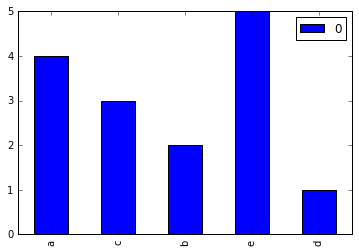

In [3]:
##### TEST CELL #####
import pandas
from collections import Counter
a = ['a', 'a', 'a', 'a', 'b', 'b', 'c', 'c', 'c', 'd', 'e', 'e', 'e', 'e', 'e']
letter_counts = Counter(a)
print(letter_counts)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

In [12]:
#### TEST CELL ####
count = 50
words = ['A', 'X', 'A', 'P', 'L']
for i, w1 in enumerate(words):
    H = {} 
    for w2 in (words[:i] + words[i+1:]):
        H[w2] = [int(H[w2])+count if w2 in H else count]
        #if w2 in H:
        #    H[w2] += count
        #else:
        #    H[w2] = count
    print w1, H
print
print(words.remove('A'))
wset = set(words)
for i, w1 in enumerate(wset):
    H = {} 
    for w2 in words:
        if w2 in H:
            H[w2] += count
        else:
            H[w2] = count
    print w1, H

A {'A': [50], 'X': [50], 'L': [50], 'P': [50]}


TypeError: int() argument must be a string or a number, not 'list'

In [27]:
filename = 'stop_words.txt'
with open(filename, 'r') as f:
    for line in f.readlines():
        m = line.strip('\n[]').split(',')
        n = [x.strip(' ').strip('u').strip("'") for x in m]

w = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 
     'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 
     'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
     'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
     'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 
     'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
     'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 
     'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 
     'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 
     'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
     'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', "ain't", "aren't", "couldn't", "didn't", "doesn't", "hadn't", 
     "hasn't", "haven't", "isn't", 'ma', "mightn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't", 
     "weren't", "won't", "wouldn't", "don't", "can't"]
print w
print len(w)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [5]:
freq_words = set()
features = set()
with open('5-4words.txt', 'r') as f:
    count = 0
    for line in f.readlines():
        if count < 10000:
            freq_words.add(line.strip())
        else:
            features.add(line.strip())
        count += 1

print(count)
print len(freq_words)
print len(features)

11000
10000
1000


In [4]:
word1 = "megan"
word2 = "awesome"
key = tuple((word1, word2, 'cos'))
total = 4.56
print(key)
print str(key), total


('megan', 'awesome', 'cos')
('megan', 'awesome', 'cos') 4.56
